In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Gemini Function Calling to Get Real-Time Company News and Insights

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/function-calling/use_case_company_news_and_insights.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Ffunction_calling%2Fuse_case_company_news_and_insights.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/function-calling/use_case_company_news_and_insights.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/function-calling/use_case_company_news_and_insights.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
| Author(s) | [Ishana Shinde](https://github.com/ishana7), [Kristopher Overholt](https://github.com/koverholt) |

## Getting Started

### Install Vertex AI SDK and other required packages

In [ ]:
!pip install --upgrade --quiet google-cloud-aiplatform requests

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "mktg-dsc-prod-f0xt"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [ ]:
import requests
import json
from IPython.display import display, Markdown
from vertexai.generative_models import (
    FunctionDeclaration,
    GenerativeModel,
    GenerationConfig,
    Part,
    Tool,
)

### Define functions and parameter descriptions

Define function declarations that will be used as tools for Gemini by specifying the function details as a dictionary in accordance with the [OpenAPI JSON schema](https://spec.openapis.org/oas/v3.0.3#schemawr).

You'll define four tools to fetch various company and financial information, including stock prices, company overviews, news for a given company, and news sentiment for a given topic:

In [9]:
get_domain = FunctionDeclaration(
    name="get_domain",
    description="Fetch the domain details of a given company",
    parameters={
        "type": "object",
        "properties": {
            "company_name": {
                "type": "string",
                "description": "The name of the company",
            }
        },
    },
)
get_contacts_by_company_domain = FunctionDeclaration(
    name="get_contacts_by_company_domain",
    description="Fetch the contacts for a given company domain",
    parameters={
        "type": "object",
        "properties": {
            "company_domain": {
                "type": "string",
                "description": "The domain of the company",
            }
        },
     },
)


get_stock_price = FunctionDeclaration(
    name="get_stock_price",
    description="Fetch the current stock price of a given company",
    parameters={
        "type": "object",
        "properties": {
            "ticker": {
                "type": "string",
                "description": "Stock ticker symbol for a company",
            }
        },
    },
)

get_company_overview = FunctionDeclaration(
    name="get_company_overview",
    description="Get company details and other financial data",
    parameters={
        "type": "object",
        "properties": {
            "ticker": {
                "type": "string",
                "description": "Stock ticker symbol for a company",
            }
        },
    },
)

get_company_news = FunctionDeclaration(
    name="get_company_news",
    description="Get the latest news headlines for a given company.",
    parameters={
        "type": "object",
        "properties": {
            "tickers": {
                "type": "string",
                "description": "Stock ticker symbol for a company",
            }
        },
    },
)

get_news_with_sentiment = FunctionDeclaration(
    name="get_news_with_sentiment",
    description="Gets live and historical market news and sentiment data",
    parameters={
        "type": "object",
        "properties": {
            "news_topic": {
                "type": "string",
                "description": """News topic to learn about. Supported topics
                               include blockchain, earnings, ipo,
                               mergers_and_acquisitions, financial_markets,
                               economy_fiscal, economy_monetary, economy_macro,
                               energy_transportation, finance, life_sciences,
                               manufacturing, real_estate, retail_wholesale,
                               and technology""",
            },
        },
    },
)

### Wrap function declarations in a tool

Now, you can define a tool that will allow Gemini to select from the set of functions we've defined:

In [10]:
company_insights_tool = Tool(
    function_declarations=[
        get_domain,
        get_contacts_by_company_domain,
        get_stock_price,
        get_company_overview,
        get_company_news,
        get_news_with_sentiment,
    ],
)

### Company and financial information API

Alpha Vantage provides real-time and historical financial market data through a set of data APIs. In this tutorial, you'll use the Alpha Vantage API to get stock prices, company information, and news about different industries.

You can register for a free developer API key at [Alpha Vantage](https://www.alphavantage.co/). Once you have an API key, paste it into the cell below:

In [11]:
# API key for company and financial information
API_KEY = "K9DLPSF1QEUA1N1G"
dsc_apikey='AeP8SOQcGgKJHMwp4FSom9NlrGvuEphG'

You'll use this API key throughout the rest of this notebook to make API requests and get information about various companies and industries.

### Define Python functions and a function handler

Define Python functions that you'll invoke to fetch data from an external API:

In [12]:
def get_domain(content):
    url = f"https://dsc.cisco.com/domainfinder/pro?company_name={content['company_name']}&apikey={dsc_apikey}"
    api_request = requests.get(url)
    return api_request.text



def get_contacts_by_company_domain(company_domain: str, country: str='United States', persona: str = 'ITDM', mgt_level: str = '', version: str = '', debug: str = '', rpp: int = 20) -> list:
        """
        Returns the number of contacts from ZoomInfo's data that meet the specified search criteria.

        Args:
            company_domain (str): The company domain (required).
            country (str): The country for the contacts (required).
            persona (str, optional): Examples include HR, ITDM, or Ops. Defaults to 'ITDM'.
            mgt_level (str, optional): Example exec (officers/executives) or management (VP, Director, and Managers) or All. Defaults to ''.
            version (str, optional): Version tag. Defaults to ''.
            debug (str, optional): Debug tag. Defaults to ''.
            rpp (int, optional): Number of results to return. Defaults to 20.

        Returns:
            list: The response from ZoomInfo.

        Raises:
            requests.exceptions.HTTPError: If the API request fails.
        """
        
        # Access the value of the "company_domain" key
        domain = company_domain['company_domain']
        search_payload = {
            'companyWebsite': domain,
            'country': country,
            'sortBy': 'hierarchy',
            'sortOrder': 'descending',
            'department': 'Information Technology',
            'requiredFields': 'email,phone',
            'locationSearchType': 'Person',
            'rpp': rpp
        }

        payload = json.dumps(search_payload)

        url = f'https://dsc.cisco.com/v1/zi/contact/search?payload-type=raw&apikey={dsc_apikey}&version=test&target-safety=off'
        s = requests.Session()
        s.headers.update({'Content-type': 'application/json'})
        response = s.post(url, data=payload.encode('utf-8'), timeout=5)
        # logger.info(f' Company ID: {company_id} Response')
        if response.status_code == 200:
            return response.json()


def get_company_overview_from_api(content):
    url = f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={content['ticker']}&apikey={API_KEY}"
    api_response = requests.get(url)
    return api_response.text


def get_company_news_from_api(content):
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={content['tickers']}&limit=20&sort=RELEVANCE&apikey={API_KEY}"
    api_response = requests.get(url)
    return api_response.text


def get_news_with_sentiment_from_api(content):
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&topics={content['news_topic']}&limit=20&sort=RELEVANCE&apikey={API_KEY}"
    api_request = requests.get(url)
    return api_request.text

Define a function handler that maps function call names (from your function declarations) to actual Python functions that call APIs:

In [13]:
function_handler = {
    "get_domain": get_domain,
    "get_contacts_by_company_domain" : get_contacts_by_company_domain,
    "get_company_overview": get_company_overview_from_api,
    "get_company_news": get_company_news_from_api,
    "get_news_with_sentiment": get_news_with_sentiment_from_api,
}

### Initialize model

Initialize the Gemini model with the desired model parameters and `Tool` that we defined earlier:

In [14]:
gemini_model = GenerativeModel(
    "gemini-1.5-pro-001",
    generation_config=GenerationConfig(temperature=0),
    tools=[company_insights_tool],
)

### Initialize chat session

In [15]:
chat = gemini_model.start_chat()

### Define a helper function to send chat messages and handle function calls & responses

Before you start chatting with the Gemini model and making function calls, recall that Gemini Function Calling predicts a function call from a set of functions then returns structured information about which function to call and which parameters to use.

The following diagram shows the data flow and step-by-step process that occurs with Gemini Function Calling for a given conversation turn (i.e., a single input prompt from the user and output summary to the user):

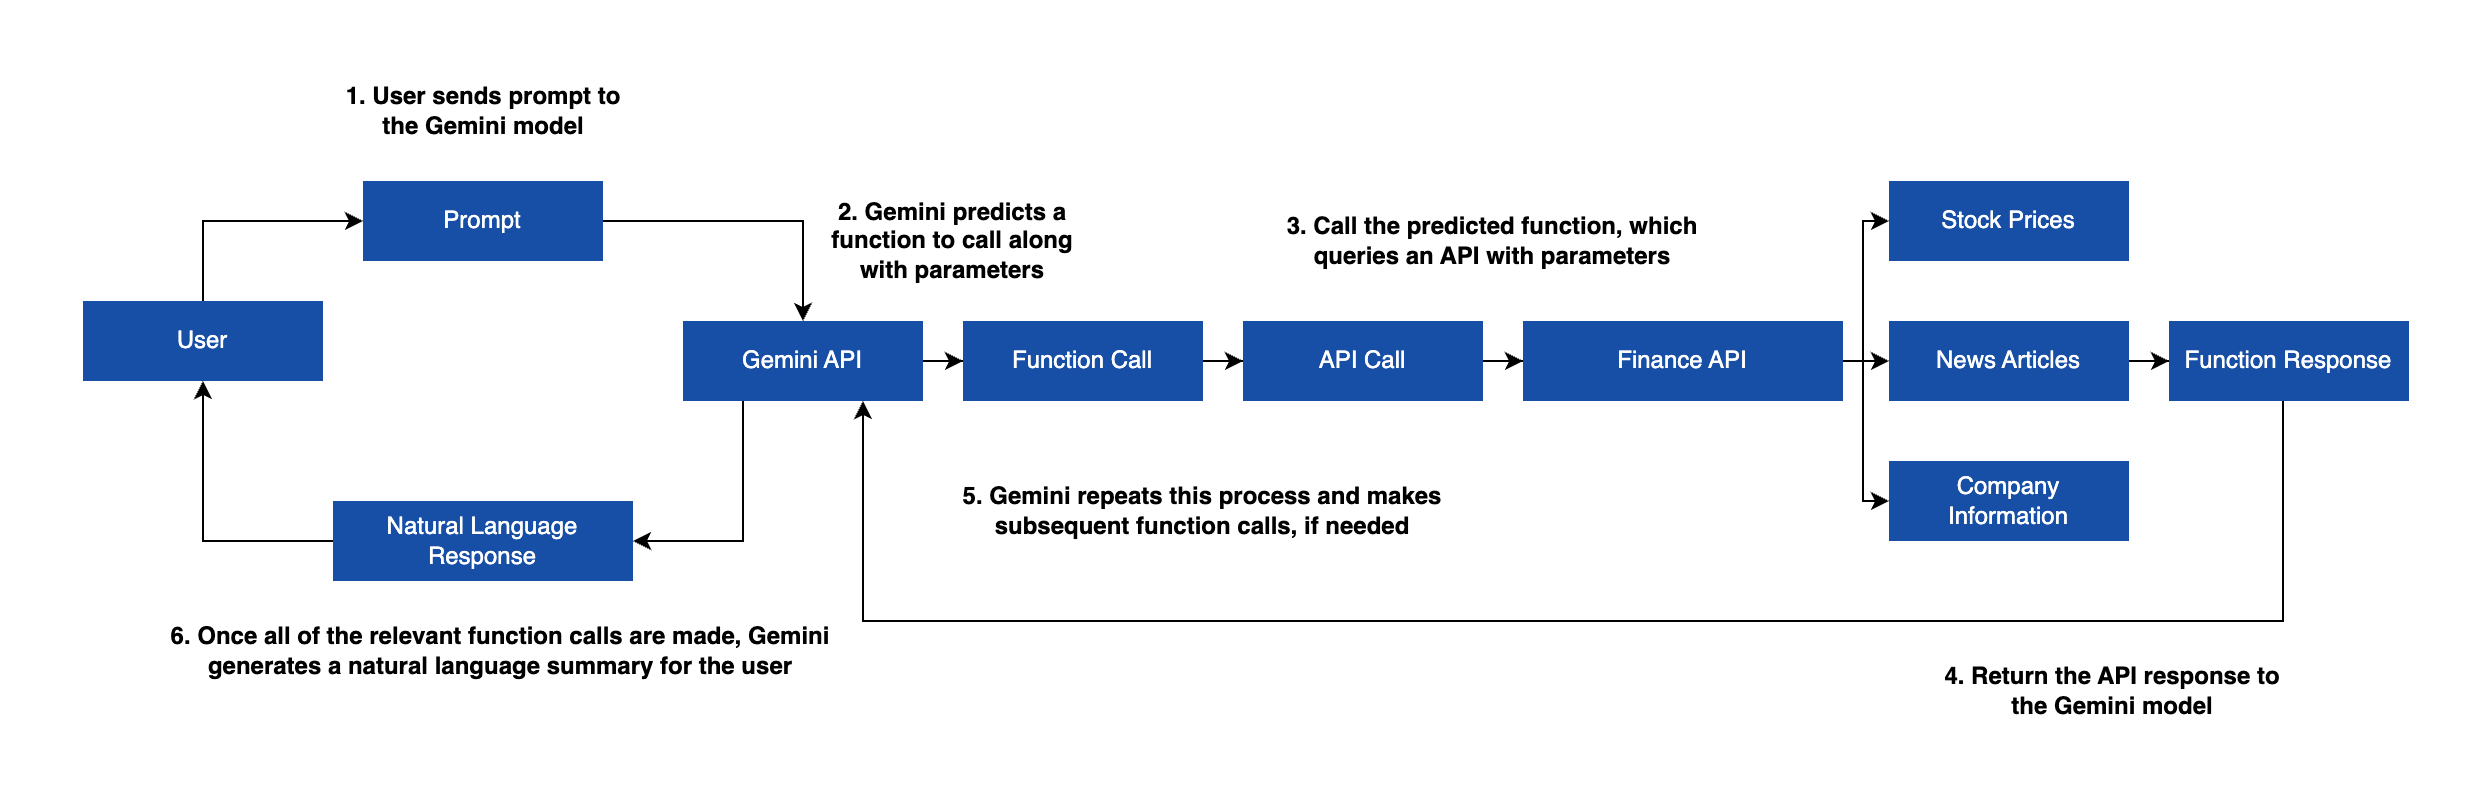

Rather than having to manually inspect the predicted function names and function parameters and then repeatedly invoking API calls, the following helper function automates the process of handling API calls and responses to and from the Gemini model:

In [26]:
def send_chat_message(prompt):
    display(Markdown("#### Prompt"))
    print(prompt, "\n")
    prompt += """
    Give a concise, high-level summary. Only use information that you learn from 
    the API responses. 
    """

    # Send a chat message to the Gemini API
    response = chat.send_message(prompt)

    # Handle cases with multiple chained function calls
    function_calling_in_process = True
    while function_calling_in_process:
        # Extract the function call response
        function_call = response.candidates[0].content.parts[0].function_call

        # Check for a function call or a natural language response
        if function_call.name in function_handler.keys():
            # Extract the function call name
            function_name = function_call.name
            display(Markdown("#### Predicted function name"))
            print(function_name, "\n")

            # Extract the function call parameters
            params = {key: value for key, value in function_call.args.items()}
            display(Markdown("#### Predicted function parameters"))
            print(params, "\n")

            # Invoke a function that calls an external API
            function_api_response = function_handler[function_name](params)
           

            
            display(Markdown("#### API response"))
            # print(function_api_response[:500], "...", "\n")

            # Send the API response back to Gemini, which will generate a natural language summary or another function call
            response = chat.send_message(
                Part.from_function_response(
                    name=function_name,
                    response={"content": function_api_response},
                ),
            )
        else:
            function_calling_in_process = False

    # Show the final natural language summary
    display(Markdown("#### Natural language response"))
    display(Markdown(response.text.replace("$", "\\\$")))

In the above helper function, the `while` loop handles cases in which the Gemini model predicts two or more chained Function Calls. The code within the `if` statement handles the invocation of function calls and API requests and responses. And the line of code in the `else` statement stops the Function Calling logic in the event that Gemini generates a natural language summary.

### Ask questions about various companies and topics

Now that you've defined your functions, initialized the Gemini model, and started a chat session, you're ready to ask questions!

### Sample prompt related to stock price

Start with a simple prompt that asks about a stock price:

In [29]:
send_chat_message("What is the ultimate_domain for Geico? List 3 contacts with name and job_title for the ultimate_domain")

#### Prompt

What is the ultimate_domain for Geico? List 3 contacts with name and job_title for the ultimate_domain 



#### Predicted function name

get_domain 



#### Predicted function parameters

{'company_name': 'Geico'} 



#### API response

#### Predicted function name

get_contacts_by_company_domain 



#### Predicted function parameters

{'company_domain': 'berkshirehathaway.com'} 



#### API response

#### Natural language response

The ultimate domain for Geico is berkshirehathaway.com. Here are 3 contacts for berkshirehathaway.com: Elizabeth McKeever, Program IT Communications & Organization Change Management Owner; Tou Tanonsai, Manager, Information Technology; F. Gsae, Manager, Information Technology. 


In [27]:
send_chat_message("Which contacts are available for Geico?")

#### Prompt

Which contacts are available for Geico? 



#### Predicted function name

get_domain 



#### Predicted function parameters

{'company_name': 'Geico'} 



#### API response

#### Predicted function name

get_contacts_by_company_domain 



#### Predicted function parameters

{'company_domain': 'geico.com'} 



#### API response

#### Natural language response

I found 20 contacts for Geico.  The top 3 contacts are Sarah Rigual, Technical Systems Analyst II & Product Owner; Jeremiah Martin, Agency Owner and Principal Agent; and Kimberly Patten, Vice President, Information Technology. 


In [ ]:
send_chat_message("Where is the headquarters of Geico?")

#### How it works

For this prompt, Gemini predicted the `get_company_overview()` function along with the ticker symbol `GOOG`. The logic within your helper function handled the API call, and the natural language response generated by Gemini includes information about financial metrics, a company description, and stock details.

### Sample prompt for information about multiple companies

Now, see what happens what you ask about two different companies:

In [ ]:
send_chat_message("Give me a company overview of Walmart and The Home Depot")

#### How it works

Great! This time, Gemini predicted the use of two subsequent function calls to `get_company_overview()`, one for each ticker symbol. The logic within your helper function handled the chained function calls, and the natural language response generated by Gemini includes information about both companies.

### Sample prompt related to company news

Ask a question about the latest news related to a particular company:

In [ ]:
send_chat_message("What's the latest news about Google?")

#### How it works

For this prompt, Gemini predicted the `get_company_news()` function. The logic within your helper function handled the API call, and the natural language response generated by Gemini includes the latest news related to Google.

### Sample prompt related to industry news

Now, try sending a prompt about news for a particular industry:

In [ ]:
send_chat_message("Has there been any exciting news related to real estate recently?")

#### How it works

This time, Gemini predicted the `get_news_with_sentiment()` function along with the function parameter `real_estate` as defined in your `FunctionDeclaration`. The logic within your helper function handled the API call, and the natural language response generated by Gemini includes the latest news and sentiment in the real estate industry.

### Summary

This tutorial highlights how Gemini Function Calling helps bridge the gap between raw data and actionable insights. This functionality empowers users to ask questions in natural language, our application code makes API calls to retrieve the latest relevant information, then the Gemini model summarizes the results from one or more API calls.

We're excited to see how you'll use Gemini Function calling to build generative AI applications that can help users make informed decisions, whether they are investors like Jane, or anyone who's looking to combine the power of generative AI models with reliable and up-to-date information from external data sources.

Feel free to try sending additional prompts, editing the function declarations, or even adding your own. Happy Function Calling!